In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as ss
from sklearn import tree

In [7]:
#load data, in sparse format
def load_data(filename):
    f = open('../dorothea/%s.data' % filename)
    I,J = [],[]
    for k in range(100000):
        line = f.readline()
        if len(line) == 0:
            print ('done')
            break

        line = [int(x) for x in line.split()]
        J.extend(line)
        I.extend(k for i in range(len(line)))

    return ss.coo_matrix((np.ones(len(I)), (I,J)))


def load_labels(filename):
    f = open('../dorothea/%s.labels' % filename)
    y = []
    for k in range(100000):
        line = f.readline()
        
        if len(line) == 0:
            print ('done')
            break
        y.append(int(line))
    return np.array(y)


Xtrain = load_data('dorothea_train')
ytrain = load_labels('dorothea_train')

Xtest= load_data('dorothea_valid')
ytest = load_labels('dorothea_valid')

print (Xtrain.shape,  Xtest.shape, Xtrain.nnz)

done
done
done
done
(800, 100001) (350, 100001) 727760


In [17]:
def get_class_balance(y):
    #fill me in
    return len(y[y==1])/len(y), len(y[y==-1])/len(y)

print ('class balance is currently %.2f  +1, %.2f -1' % get_class_balance(ytrain))

class balance is currently 0.10  +1, 0.90 -1


This task is different from the other tasks we have done before since the class imbalance is very high. 

In [30]:
def get_misclass(y,yhat):
    #fill me in
    return np.around(np.sum(y!=yhat)/len(y), 3)


def get_f1(y,yhat):
    #fill me in
    def confusion_matrix(y, yhat):
        A = np.empty(shape=(2,2), dtype=int)
        A[0,0] = len(y[(y==yhat)&(y==1)])
        A[1,1] = len(y[(y==yhat)&(y==-1)])
        A[0,1] = len(y[(y!=yhat)&(y==1)])
        A[1,0] = len(y[(y!=yhat)&(y==-1)])
        return A

    def precision(A): return A[0,0]/np.sum(A[:, 0])
    def recall(A): return A[0,0]/np.sum(A[0, :])

    A = confusion_matrix(y, yhat)
    p, r = precision(A), recall(A)
    return np.around(2*p*r/(p+r), 3)

depth = 3
clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth, class_weight='balanced')
clf = clf.fit(Xtrain, ytrain)

print (get_misclass(ytrain, clf.predict(Xtrain) ), get_f1(ytrain, clf.predict(Xtrain) ))
print (get_misclass(ytest, clf.predict(Xtest) ), get_f1(ytest, clf.predict(Xtest) ))

0.041 0.772
0.071 0.603


In [35]:
train_f1, test_f1 = [], []

for depth in range(1, 11):
    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth,\
                                        class_weight='balanced')
    clf = clf.fit(Xtrain, ytrain)

    train_f1.append(get_f1(ytrain, clf.predict(Xtrain)))
    test_f1.append(get_f1(ytest, clf.predict(Xtest)))

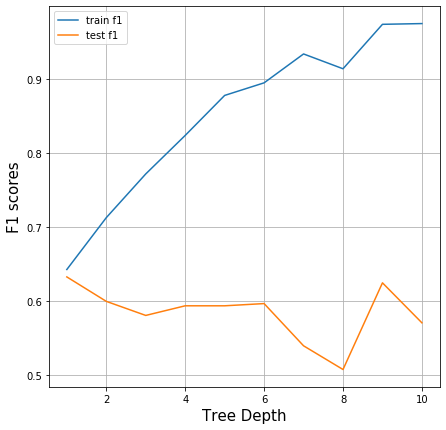

In [45]:
plt.figure(figsize=(7,7))
plt.plot(range(1, 11), train_f1, label="train f1")
plt.plot(range(1, 11), test_f1, label="test f1")
plt.ylabel("F1 scores", fontsize=15)
plt.xlabel("Tree Depth", fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

In [65]:
def KFold(n:int, k:int): 
    a = np.arange(n)
    np.random.seed(42)
    np.random.shuffle(a)
    folds = []
    p = int(n//k)
    for i in range(k-1):
        fold = a[i*p:(i+1)*p]
        folds.append((fold, a[~np.isin(a, fold)]))
    fold = a[(k-1)*p:]
    folds.append((fold, a[~np.isin(a, fold)]))
    return folds

In [104]:
folds = KFold(Xtrain.shape[0], 5)
depth = 1
fold_train_f1, fold_eval_f1 = [], []
for eval, train in folds:
    X_fold_train, y_fold_train = ss.coo_matrix(Xtrain).tocsr()[train], ytrain[train]
    X_fold_eval, y_fold_eval = ss.coo_matrix(Xtrain).tocsr()[eval], ytrain[eval]

    clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth,\
                                        class_weight='balanced')
    clf = clf.fit(X_fold_train, y_fold_train)

    fold_train_f1.append(get_f1(y_fold_train, clf.predict(X_fold_train)))
    fold_eval_f1.append(get_f1(y_fold_eval, clf.predict(X_fold_eval)))    

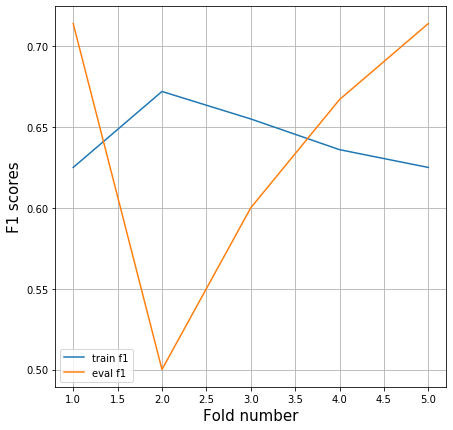

In [105]:
plt.figure(figsize=(7,7))
plt.plot(range(1, 6), fold_train_f1, label="train f1")
plt.plot(range(1, 6), fold_eval_f1, label="eval f1")
plt.ylabel("F1 scores", fontsize=15)
plt.xlabel("Fold number", fontsize=15)
plt.grid(True)
plt.legend()
plt.show()

In [108]:
eval_f1 = []
for depth in range(1, 11):
    temp_fold_eval_f1 = []
    for eval, train in folds:
        X_fold_train, y_fold_train = ss.coo_matrix(Xtrain).tocsr()[train], ytrain[train]
        X_fold_eval, y_fold_eval = ss.coo_matrix(Xtrain).tocsr()[eval], ytrain[eval]

        clf = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=depth,\
                                            class_weight='balanced')
        clf = clf.fit(X_fold_train, y_fold_train)

        #fold_train_f1.append(get_f1(y_fold_train, clf.predict(X_fold_train)))
        temp_fold_eval_f1.append(get_f1(y_fold_eval, clf.predict(X_fold_eval)))
    eval_f1.append(np.mean(temp_fold_eval_f1))

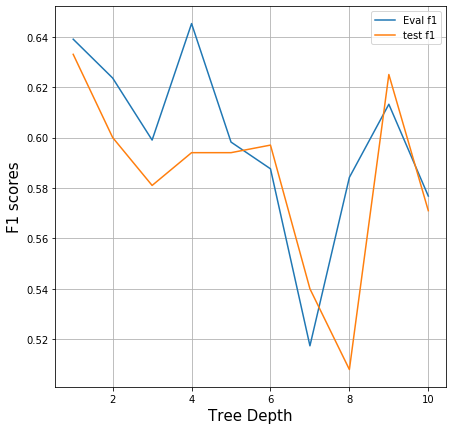

In [109]:
plt.figure(figsize=(7,7))
plt.plot(range(1, 11), eval_f1, label="Eval f1")
plt.plot(range(1, 11), test_f1, label="test f1")
plt.ylabel("F1 scores", fontsize=15)
plt.xlabel("Tree Depth", fontsize=15)
plt.grid(True)
plt.legend()
plt.show()